![alt text](https://www.msengineering.ch/typo3conf/ext/msengineering/Resources/Public/Images/Logo/mse-full.svg "MSE Logo") 

# AnTeDe Practical Work 8: Name Generation with RNN

by Fabian Märki

## Summary
The aim of this lab is to get an understanding of building a RNN model using Keras. The task is to train a character-level language models that generates new baby names (but feel free to change this to e.g. new start-up names or city names etc.). 

### Source
- https://github.com/JKH4/name-generator/blob/master/dev/2018-05-18_JKH_NameGen-Main.ipynb

This lab contains assigments (although most of the code is given). <font color='green'>Questions are written in green.</font>

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import random
import sys
import io
import time
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import json

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GRU, SimpleRNN, Bidirectional, InputLayer

from tensorflow.keras.optimizers import Adam

from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from more_itertools import sort_together

### Your Task

Below you find working code, most of it does not need your attention and can be used as is (e.g. `load_data`).

Your task is to get hands on experience with Keras and RNNs by trying different options on how to build a RNN and on how to tune it. 
<font color='green'><br>After you created a model with good performance, please write a short summary about your experience: what works well, what did not work well, what influenced the performance of the model, did you experience strange behaviors, how did you analyze the data, how do you estimate the performance of your model, what possible further improvements you can consider.</font>

<font color='green'>Modify the function `create_model` </font>according your intuition on how the model could be improved. Options you might want to try (please experiment with at least four of them):
- try different RNN types (SimpleRNN, LSTM, GRU - see [here](https://keras.io/layers/recurrent))
- try different number of RNN units (see `parameters`)
- use regularization techniques (e.g. dropout)
- use options provided by the RNN types (e.g. arguments "dropout" and "recurrent_dropout" - see [here](https://keras.io/layers/recurrent))
- stack several RNN layers (see [here](https://keras.io/getting-started/sequential-model-guide/) and search for "Stacked LSTM for sequence classification")
- try different optimizers (see [here](https://keras.io/optimizers/))
- get more inspiration from [here](https://ruder.io/deep-learning-nlp-best-practices)

<font color='green'>You might also want to have a look at the `parameters` variable below and modify it according your needs.</font> 



<font color='green'>Please provide a summary of your experience right here.</font>

### Results
The following approaches were tested


\\
#### Different RNN Types
__Setup:__ 
- `rnn_types[SimpleRNN, LSTM, GRU]` each with `lr=0.003, rnn_units=16, epochs=12`

__Findings:__
- The accuracy of the `LSTM` and `GRU` was slightly better (~ 1-2%) than the accuracy of the `SimpleRNN`. But the difference is really small and we expected a bigger gap between the different types.

\\
#### Different Number of RNN units
__Setup:__
- `rnn_units=[8, 16, 32, 64, 128]` for `rnn_types=[LSTM]` with `lr=0.003, epochs=12`

__Findings:__
- The accuracy increased with using a higher number of RNN units. The accuracy is around 10% higher for using 128 instead of 8 rnn_units.

\\
#### Regularization Techniques
__Setup:__
- `dropout` and `recurrent_dropout` with `dropout_rates=[0.0, 0.1, 0.3]` for `rnn_types=[LSTM]` with `lr=0.003, rnn_units=128, epochs=12`

__Findings:__
- When using a regular droput the performance degrades a lot faster than when using the recurrent one. 
- The higher the dropout rate is, the more nonsense names we obtain

\\
#### Stack several layers
__Setup:__
- `stacks=[1, 2, 3, 4]` with a `base_unit=[64]` for `rnn_types=[LSTM]` with `lr=0.003, epochs=12, dropout=0.0, recurrent_dropout=0.2`

__Findings:__
- A number of 3 stacks gives us the best performance. When using 4 stacks the performance decreases. It is really hard to say why this happens. Maybe a longer training would be needed.



In [2]:
def create_model(parameters):
    length_of_sequence = parameters["trainset_infos"]['length_of_sequence']
    number_of_chars = parameters["trainset_infos"]['number_of_chars']
    
    model = Sequential()
    model.add(InputLayer(input_shape=(length_of_sequence, number_of_chars)))
    
    for index, unit in enumerate(parameters["rnn_units"]):
        is_last = index != len(parameters['rnn_units']) - 1
            
        if parameters["rnn_type"] == 'SimpleRNN':
            model.add(SimpleRNN(unit, 
                                dropout=parameters['dropout'], 
                                recurrent_dropout=parameters['recurrent_dropout'], 
                                return_sequences=is_last))
        elif parameters["rnn_type"] == 'LSTM':
            model.add(LSTM(unit, 
                           dropout=parameters['dropout'], 
                           recurrent_dropout=parameters['recurrent_dropout'], 
                           return_sequences=is_last))
        elif parameters["rnn_type"] == 'GRU':
            model.add(LSTM(unit, 
                           dropout=parameters['dropout'], 
                           recurrent_dropout=parameters['recurrent_dropout'], 
                           return_sequences=is_last))
        
    if parameters['dropout'] > 0.0:
        model.add(Dropout(parameters['dropout']))
        
    model.add(Dense(number_of_chars, activation='softmax'))
    
    if parameters.get("verbose"):
        model.summary()
        
    return model

def load_data(parameters):
    length_of_sequence = 5
    padding_start = '#'
    padding_end = '*'
    file_url = parameters["file_url"]

    text = ''
    with io.open(get_file(os.path.basename(file_url), origin=file_url), encoding='utf-8') as f:
        text = f.read().lower()

    names = pd.read_csv(io.StringIO(text), names=['name'], comment='#', header=None, keep_default_na=False, na_values=[])
    names['name'] = names['name'].map(lambda n: n.replace(padding_start, ''))    # replace characters used for training
    names['name'] = names['name'].map(lambda n: n.replace(padding_end, ''))    # replace characters used for training
    names['name'] = names['name'].map(lambda n: padding_start + n + padding_end) 
    
    data_dict = {}
    data_dict['name_list'] = names['name']
    data_dict['char_list'] = sorted(list(set(data_dict['name_list'].str.cat() + '*')))
    data_dict['char_to_ix'] = { ch:i for i,ch in enumerate(data_dict['char_list']) }
    data_dict['ix_to_char'] = { i:ch for i,ch in enumerate(data_dict['char_list']) }
           
    # Extract target names to list (currently '#name*')
    training_names = data_dict['name_list'].tolist()
    
    # Extract padding characters
    padding_start = training_names[0][0]
    padding_end = training_names[0][-1]

    # Extract target character convertors
    # This will be used to convert a character to its "one hot index" and vice versa (cf Keras to_categorical())
    c2i = data_dict['char_to_ix']
    i2c = data_dict['ix_to_char']
    
    # Extract the target number of characters in all target names
    # This will be used to convert character index in its "one hot" representation (cf Keras to_categorical())
    number_of_chars = len(data_dict['char_list'])
    # Pad target names with enough (lengh_of_sequence) padding characters (result '##...##name**...**' )
    # The goal is  be sure that, for each name, the first training data is X[0] = '##...##'
    # and Y[0] = First actual character of the name
    training_names = [
        padding_start * (length_of_sequence - 1) + n + padding_end * (length_of_sequence - 1) for n in training_names
    ]

    # Init X and Y as list
    X_list = []
    Y_list = []

    # Init counter for visual feedback
    counter = 0 if parameters["verbose"] else None
    
    for name in training_names:
        # Slide a window on the name, one character at a time
        for i in range(max(1, len(name) - length_of_sequence)):
            # Extract the new sequence and the character following this sequence
            new_sequence = name[i:i + length_of_sequence]
            target_char = name[i + length_of_sequence]
            
            # Add the new sequence to X (input of the model)
            X_list.append([to_categorical(c2i[c], number_of_chars) for c in new_sequence])
            # Add the following character to Y (target to be predicted by the model)
            Y_list.append(to_categorical(c2i[target_char], number_of_chars))
        
        # visual feedback
        if parameters["verbose"]:
            counter += 1
            #print(counter) if counter % 100 == 0 else print('.', end='')
            
    # make sure number of elements allignes with batch size
    offset = len(X_list) % parameters["batch_size"]
    if offset != 0:
        elements_to_copy = parameters["batch_size"] - offset
        X_list.extend(X_list[:elements_to_copy])
        Y_list.extend(Y_list[:elements_to_copy])
        
    # Convert X and Y to numpy array
    x_train = np.array(X_list)
    y_train = np.array(Y_list)
    
    # Extract the number of training samples
    m = len(x_train)
    
    # Create a description of the trainset
    parameters["trainset_infos"] = {
        'length_of_sequence': length_of_sequence,
        'number_of_chars': number_of_chars,
        'm': m,
        'padding_start': padding_start,
        'padding_end': padding_end,
    }

    print(
        '\n{} names split in {} training sequence of {} encoded chars !'.format(counter, m, length_of_sequence)
    ) if parameters["verbose"] else None

    # Visual feedbacks
    if parameters["verbose"]:
        print('X shape: {}'.format(x_train.shape))
        print('Y shape: {}'.format(y_train.shape))

        print('X[0] = {}'.format(x_train[0]))
        print('Y[0] = {}'.format(y_train[0]))

        print('Training set size: {}'.format(m))
        print('length_of_sequence: {}'.format(length_of_sequence))
        print('number_of_chars: {}'.format(number_of_chars))
        print('some names: {}'.format(names['name'][:5]))
    
                 
    parameters["x_train"] = x_train
    parameters["y_train"] = y_train
    parameters["word2index"] = c2i
    parameters["index2word"] = i2c                


def compile_model(model, parameters):
    optimizer = Adam(lr = parameters["learning_rates"][parameters["iter"]])

    model.compile(loss=parameters["loss_function"], optimizer=optimizer, metrics = parameters["metrics"])

        
def train_model(model, parameters):
    i = parameters["iter"]
    
    # Train the model
    h = model.fit(
        parameters["x_train"], parameters["y_train"],
        validation_data = parameters.get("validation_data"),
        batch_size = parameters["batch_size"],
        callbacks = parameters.get("callbacks"),
        initial_epoch = parameters["total_epochs"],
        epochs = parameters["total_epochs"] + parameters["epochs_to_run"][i]
    )

    history = parameters["history"]
    # Update history
    for key, val in h.history.items():
        col = history.get(key)
        
        if col is None:
            col = np.array([])
        
        history[key] = np.append(col, val)
        
    
    # Update the training session info
    parameters['total_epochs'] += parameters['epochs_to_run'][i]
    
    
def plot_class_balance(y, title=''):
    (unique, counts) = np.unique(y, return_counts=True)
    (unique, counts) = sort_together([unique, counts])

    plt.bar(unique, counts, align='center')
    plt.xticks(np.arange(len(unique)), unique)
    plt.xlabel('label')
    plt.ylabel('count')
    plt.title(title)

    plt.show()
    
    
def plot_confusion_matrix(y_true, y_pred, title=''):
    classes = list(set(list(y_true) + list(y_pred)))
    classes.sort()

    cmm = confusion_matrix(y_true, y_pred)

    print('Set Population: {}'.format(cmm.sum()))
    print('Accuracy: {:.4f}'.format(float(cmm.trace()) / cmm.sum()))

    plt.figure(figsize=(10, 8))
    plt.imshow(cmm / cmm.sum(), interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()

    plt.ylim(-0.5, len(classes)-0.5)

    if classes is not None:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45, size='x-large')
        plt.yticks(tick_marks, classes, size='x-large')

    for y in range(cmm.shape[0]):
        for x in range(cmm.shape[1]):
            if cmm[y, x] > 0:
                plt.text(x, y, '%.0i' % cmm[y, x],
                         horizontalalignment='center',
                         verticalalignment='center')
    plt.show()
    

def plot_training_session(parameters, plots=["accuracy", "val_accuracy"]):
    history = parameters["history"]
    
    x = range(len(history[plots[0]]))
    
    for label in plots:
        vals = history.get(label)
        if vals is not None:
            plt.plot(x, vals, label = label)
        else:
            print("There is no data for", label)
    
    plt.xlabel('epoch')
    plt.title('Progress')
    plt.legend()
    plt.show()
    
def generate_name(model, parameters, start_char = None, name_max_length = 25):
    '''
    Generate some name with the RNN model
    
    ## Inputs:
    model (Keras model): 
    parameters (dict): the parameters
    name_max_length (integer): max size of the generated name
    verbose (boolean): show some feedbacks
    ## Outputs:
    generated_name (string): name generated by the RNN
    (probability, gap): few numbers about this generated name
        probability: probability to generate this name (cummulative probability to select each character)
        ecart: gap between best name and this name (cummulative sum of gaps between selected character and best character)
        
    '''
    trainset_infos = parameters["trainset_infos"]
    # Extract the number of unique character in trainset
    dict_size = trainset_infos["number_of_chars"]
    
    # Extract the size of an input sequence
    sequence_length = trainset_infos["length_of_sequence"]
    
    # Extract utils dictionnary to convert character to one hot index and vice versa
    # in this context 'word' is meant to be a character
    i2c = parameters["index2word"]
    c2i = parameters["word2index"]
    
    # Extract padding character
    padding_start = trainset_infos["padding_start"]
    
    # Init a name full of padding_start character
    generated_name = padding_start * (sequence_length + name_max_length)

    # Init counters
    probability = 1
    gap = 0

    if start_char is not None:
        generated_name = generated_name[:(sequence_length - 1)] + start_char + generated_name[sequence_length:]
    
    # Generate new character from current sequence
    for i in range(name_max_length):
        # Extract current sequence from generated character
        x_char = generated_name[i:i+sequence_length]
        
        # Convert current sequence to one hot vector
        x_cat = np.array([[to_categorical(c2i[c], dict_size) for c in x_char]])
        
        # Predict new character probabilities
        # Actually this output a list of probabilities for each character
        p = model.predict(x_cat)

        # Extract the best character (and its probability)
        best_char = i2c[np.argmax(p)]
        best_char_prob = np.max(p)

        # Choose a random character index according to their probabilities (and its probability)
        new_char_index = np.random.choice(range(dict_size), p = p.ravel())
        new_char_prob = p[0][new_char_index]
        
        # Convert the index to an actual character
        new_char = i2c[new_char_index]
                
        # Update the generated name with the new character
        generated_name = generated_name[:sequence_length+i] + new_char + generated_name[sequence_length+i+1:]
        
        # Update counters
        probability *= new_char_prob # probabilities are multiplied
        gap += best_char_prob-new_char_prob # gaps are summed

        # Show some feedbacks
        if parameters["verbose"]:
            print(
                'i={} new_char: {} ({:.3f}) [best:  {} ({:.3f}), diff: {:.3f}, prob: {:.3f}, gap: {:.3f}]'.format(
                    i,
                    new_char,
                    new_char_prob,
                    best_char,
                    best_char_prob,
                    best_char_prob-new_char_prob,
                    probability,
                    gap
                )
            )

        # Stop the prediction loop if it reached a 'padding_end' character
        if (new_char == trainset_infos['padding_end']):
            break
    
    # Clean the generated name
    generated_name = generated_name.strip('#*')
    
    # Show some feedbacks
    print('{} (probs: {:.6f}, gap: {:.6f})'.format(generated_name, probability, gap)) if parameters["verbose"] else None

    return generated_name, {'probability': probability, 'gap': gap}

<font color='green'>You will need to tune the parameters (you probably want to have a look at 'rnn_units', and 'epochs_to_run').  Please indicate as comments the values you tried, and the best values you keep.</font>

In [3]:
parameters = {
    "verbose": True,
    "rnn_units": [16],
    "rnn_type": "SimpleRNN",
    "dropout": 0.0,
    "recurrent_dropout": 0.0,
    "iter": 0,
    "epochs_to_run": [12],
    "learning_rates": [0.003],
    "total_epochs": 0,
    "loss_function": "categorical_crossentropy", 
    "metrics": ["accuracy"],
    "batch_size": 32,
    "history": {},
    #"file_url": "https://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/male.txt"
    "file_url": "https://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/female.txt"
}

In [4]:
load_data(parameters)


5001 names split in 55584 training sequence of 5 encoded chars !
X shape: (55584, 5, 31)
Y shape: (55584, 31)
X[0] = [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]]
Y[0] = [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
Training set size: 55584
length_of_sequence: 5
number_of_chars: 31
some names: 0    #abagael*
1    #abagail*
2       #abbe*
3      #abbey*
4       #abbi*
Name: name, dtype: object


In [5]:
parameters["iter"] = 0
parameters["total_epochs"] = 0
parameters["history"] = {}

model = create_model(parameters)
compile_model(
    model,
    parameters
)

for i in range(len(parameters["epochs_to_run"])):
    parameters["iter"] = i
    train_model(model, parameters)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 16)                768       
                                                                 
 dense (Dense)               (None, 31)                527       
                                                                 
Total params: 1,295
Trainable params: 1,295
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 15s 7ms/step - loss: 1.5642 - accuracy: 0.5257
Epoch 2/12
1737/1737 [==============================] - 11s 7ms/step - loss: 1.3808 - accuracy: 0.5570
Epoch 3/12
1737/1737 [==============================] - 11s 6ms/step - loss: 1.3472 - accuracy: 0.5649
Epoch 4/12
1737/1737 [==============================] - 11s 6ms/step - loss: 1.3315 - accuracy: 0.5692
Epoch 5/12
1737/1737 [==============================] - 10s 6ms/step - loss: 1.3230 - accuracy: 0.5710
Epoch 6/12
1737/1737 [==============================] - 11s 6ms/step - loss: 1.3161 - accuracy: 0.5728
Epoch 7/12
1737/1737 [==============================] - 11s 6ms/step - loss: 1.3114 - accuracy: 0.5753
Epoch 8/12
1737/1737 [==============================] - 11s 6ms/step - loss: 1.3071 - accuracy: 0.5761
Epoch 9/12
1737/1737 [==============================] - 11s 7ms/step - loss: 1.3043 - accuracy: 0.5767
Epoch 10/12
1737/1737 [==============================] - 11s 6ms/step - loss: 1.3014

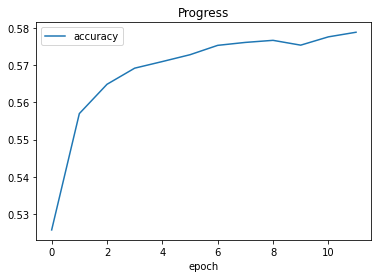

In [6]:
plot_training_session(parameters, plots=["accuracy"])

In [7]:
generate_name(model, parameters, start_char = 'j')

i=0 new_char: u (0.171) [best:  a (0.385), diff: 0.214, prob: 0.171, gap: 0.214]
i=1 new_char: n (0.168) [best:  n (0.168), diff: 0.000, prob: 0.029, gap: 0.214]
i=2 new_char: i (0.166) [best:  a (0.354), diff: 0.188, prob: 0.005, gap: 0.402]
i=3 new_char: m (0.021) [best:  a (0.278), diff: 0.257, prob: 0.000, gap: 0.659]
i=4 new_char: b (0.009) [best:  a (0.322), diff: 0.313, prob: 0.000, gap: 0.972]
i=5 new_char: i (0.190) [best:  e (0.532), diff: 0.342, prob: 0.000, gap: 1.314]
i=6 new_char: l (0.194) [best:  * (0.302), diff: 0.108, prob: 0.000, gap: 1.422]
i=7 new_char: * (0.251) [best:  * (0.251), diff: 0.000, prob: 0.000, gap: 1.422]
junimbil (probs: 0.000000, gap: 1.421658)


('junimbil', {'gap': 1.4216583222150803, 'probability': 8.599466495187638e-09})

In [8]:
generate_name(model, parameters)

i=0 new_char: a (0.182) [best:  a (0.182), diff: 0.000, prob: 0.182, gap: 0.000]
i=1 new_char: y (0.014) [best:  l (0.189), diff: 0.175, prob: 0.002, gap: 0.175]
i=2 new_char: n (0.221) [best:  l (0.321), diff: 0.100, prob: 0.001, gap: 0.275]
i=3 new_char: a (0.374) [best:  a (0.374), diff: 0.000, prob: 0.000, gap: 0.275]
i=4 new_char: y (0.008) [best:  * (0.688), diff: 0.680, prob: 0.000, gap: 0.955]
i=5 new_char: * (0.932) [best:  * (0.932), diff: 0.000, prob: 0.000, gap: 0.955]
aynay (probs: 0.000002, gap: 0.955134)


('aynay', {'gap': 0.9551337212324142, 'probability': 1.5763402981148758e-06})

## Different RNN types

------------------------------SimpleRNN------------------------------

5001 names split in 55584 training sequence of 5 encoded chars !
X shape: (55584, 5, 31)
Y shape: (55584, 31)
X[0] = [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]]
Y[0] = [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
Training set size: 55584
length_of_sequence: 5
number_of_chars: 31
some names: 0    #abagael*
1    #abagail*
2       #abbe*
3      #abbey*
4       #abbi*
Name: name, dtype: object
Model: "sequential_1"
________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 12s 6ms/step - loss: 1.5605 - accuracy: 0.5281
Epoch 2/12
1737/1737 [==============================] - 11s 6ms/step - loss: 1.3762 - accuracy: 0.5596
Epoch 3/12
1737/1737 [==============================] - 11s 6ms/step - loss: 1.3461 - accuracy: 0.5651
Epoch 4/12
1737/1737 [==============================] - 11s 6ms/step - loss: 1.3269 - accuracy: 0.5700
Epoch 5/12
1737/1737 [==============================] - 11s 6ms/step - loss: 1.3168 - accuracy: 0.5705
Epoch 6/12
1737/1737 [==============================] - 11s 6ms/step - loss: 1.3084 - accuracy: 0.5737
Epoch 7/12
1737/1737 [==============================] - 11s 6ms/step - loss: 1.3035 - accuracy: 0.5750
Epoch 8/12
1737/1737 [==============================] - 11s 6ms/step - loss: 1.2992 - accuracy: 0.5758
Epoch 9/12
1737/1737 [==============================] - 11s 6ms/step - loss: 1.2964 - accuracy: 0.5782
Epoch 10/12
1737/1737 [==============================] - 11s 6ms/step - loss: 1.2937

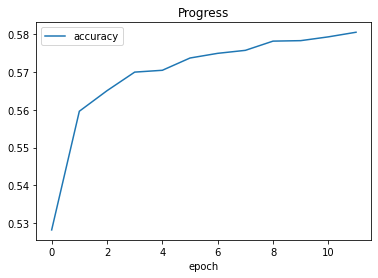

i=0 new_char: i (0.050) [best:  o (0.468), diff: 0.417, prob: 0.050, gap: 0.417]
i=1 new_char: t (0.067) [best:  s (0.165), diff: 0.098, prob: 0.003, gap: 0.515]
i=2 new_char: o (0.029) [best:  t (0.228), diff: 0.199, prob: 0.000, gap: 0.714]
i=3 new_char: n (0.473) [best:  n (0.473), diff: 0.000, prob: 0.000, gap: 0.714]
i=4 new_char: * (0.201) [best:  n (0.261), diff: 0.061, prob: 0.000, gap: 0.775]
jiton (probs: 0.000009, gap: 0.775084)
('jiton', {'probability': 9.166052304409318e-06, 'gap': 0.7750837653875351})
i=0 new_char: b (0.050) [best:  m (0.134), diff: 0.084, prob: 0.050, gap: 0.084]
i=1 new_char: y (0.018) [best:  e (0.326), diff: 0.308, prob: 0.001, gap: 0.392]
i=2 new_char: n (0.415) [best:  n (0.415), diff: 0.000, prob: 0.000, gap: 0.392]
i=3 new_char: d (0.192) [best:  n (0.555), diff: 0.363, prob: 0.000, gap: 0.755]
i=4 new_char: e (0.203) [best:  i (0.329), diff: 0.126, prob: 0.000, gap: 0.881]
i=5 new_char: l (0.096) [best:  * (0.635), diff: 0.539, prob: 0.000, gap: 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 10s 4ms/step - loss: 1.5674 - accuracy: 0.5302
Epoch 2/12
1737/1737 [==============================] - 8s 4ms/step - loss: 1.3666 - accuracy: 0.5655
Epoch 3/12
1737/1737 [==============================] - 8s 4ms/step - loss: 1.3221 - accuracy: 0.5766
Epoch 4/12
1737/1737 [==============================] - 8s 4ms/step - loss: 1.2989 - accuracy: 0.5822
Epoch 5/12
1737/1737 [==============================] - 8s 4ms/step - loss: 1.2815 - accuracy: 0.5854
Epoch 6/12
1737/1737 [==============================] - 8s 4ms/step - loss: 1.2692 - accuracy: 0.5883
Epoch 7/12
1737/1737 [==============================] - 8s 4ms/step - loss: 1.2590 - accuracy: 0.5918
Epoch 8/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.2500 - accuracy: 0.5942
Epoch 9/12
1737/1737 [==============================] - 8s 4ms/step - loss: 1.2422 - accuracy: 0.5977
Epoch 10/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.2364 - accura

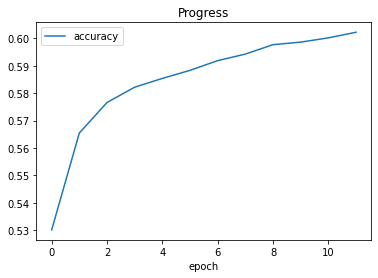

i=0 new_char: o (0.335) [best:  o (0.335), diff: 0.000, prob: 0.335, gap: 0.000]
i=1 new_char: y (0.018) [best:  r (0.138), diff: 0.120, prob: 0.006, gap: 0.120]
i=2 new_char: n (0.178) [best:  * (0.295), diff: 0.117, prob: 0.001, gap: 0.237]
i=3 new_char: * (0.170) [best:  e (0.428), diff: 0.258, prob: 0.000, gap: 0.495]
joyn (probs: 0.000183, gap: 0.495069)
('joyn', {'probability': 0.00018279883194806206, 'gap': 0.49506935477256775})
i=0 new_char: a (0.094) [best:  m (0.113), diff: 0.019, prob: 0.094, gap: 0.019]
i=1 new_char: n (0.195) [best:  l (0.237), diff: 0.042, prob: 0.018, gap: 0.061]
i=2 new_char: g (0.054) [best:  n (0.255), diff: 0.201, prob: 0.001, gap: 0.261]
i=3 new_char: e (0.477) [best:  e (0.477), diff: 0.000, prob: 0.000, gap: 0.261]
i=4 new_char: l (0.622) [best:  l (0.622), diff: 0.000, prob: 0.000, gap: 0.261]
i=5 new_char: e (0.102) [best:  l (0.333), diff: 0.231, prob: 0.000, gap: 0.492]
i=6 new_char: s (0.057) [best:  * (0.499), diff: 0.442, prob: 0.000, gap: 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 9s 4ms/step - loss: 1.5802 - accuracy: 0.5242
Epoch 2/12
1737/1737 [==============================] - 8s 4ms/step - loss: 1.3823 - accuracy: 0.5575
Epoch 3/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.3356 - accuracy: 0.5704
Epoch 4/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.3067 - accuracy: 0.5771
Epoch 5/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.2873 - accuracy: 0.5825
Epoch 6/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.2718 - accuracy: 0.5871
Epoch 7/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.2607 - accuracy: 0.5899
Epoch 8/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.2516 - accuracy: 0.5915
Epoch 9/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.2441 - accuracy: 0.5945
Epoch 10/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.2370 - accurac

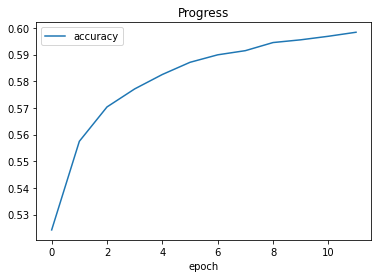

i=0 new_char: o (0.313) [best:  a (0.338), diff: 0.025, prob: 0.313, gap: 0.025]
i=1 new_char: t (0.027) [best:  r (0.206), diff: 0.179, prob: 0.008, gap: 0.204]
i=2 new_char: t (0.227) [best:  a (0.244), diff: 0.018, prob: 0.002, gap: 0.221]
i=3 new_char: a (0.279) [best:  i (0.303), diff: 0.024, prob: 0.001, gap: 0.245]
i=4 new_char: * (0.854) [best:  * (0.854), diff: 0.000, prob: 0.000, gap: 0.245]
jotta (probs: 0.000459, gap: 0.244974)
('jotta', {'probability': 0.000458880234014713, 'gap': 0.24497373402118683})
i=0 new_char: a (0.109) [best:  a (0.109), diff: 0.000, prob: 0.109, gap: 0.000]
i=1 new_char: t (0.026) [best:  l (0.262), diff: 0.236, prob: 0.003, gap: 0.236]
i=2 new_char: r (0.106) [best:  h (0.286), diff: 0.180, prob: 0.000, gap: 0.416]
i=3 new_char: i (0.571) [best:  i (0.571), diff: 0.000, prob: 0.000, gap: 0.416]
i=4 new_char: d (0.020) [best:  n (0.332), diff: 0.312, prob: 0.000, gap: 0.728]
i=5 new_char: a (0.521) [best:  a (0.521), diff: 0.000, prob: 0.000, gap: 

In [9]:
rnn_types = ['SimpleRNN', 'LSTM', 'GRU']
for rnn_type in rnn_types:
    print('-'*30 + rnn_type + '-'*30)
    parameters['rnn_type'] = rnn_type
    
    load_data(parameters)
    
    parameters["iter"] = 0
    parameters["total_epochs"] = 0
    parameters["history"] = {}

    model = create_model(parameters)
    compile_model(
        model,
        parameters
    )
    
    start = time.time()
    for i in range(len(parameters["epochs_to_run"])):
        train_model(model, parameters)
        parameters["iter"] = i
    end = time.time()
    print("Training took {0:.2f} seconds".format(end-start))
    
    plot_training_session(parameters, plots=["accuracy"])
    
    print(generate_name(model, parameters, start_char = 'j'))
    print(generate_name(model, parameters))

## Different number of RNN units

------------------------------LSTM (8)------------------------------

5001 names split in 55584 training sequence of 5 encoded chars !
X shape: (55584, 5, 31)
Y shape: (55584, 31)
X[0] = [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]]
Y[0] = [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
Training set size: 55584
length_of_sequence: 5
number_of_chars: 31
some names: 0    #abagael*
1    #abagail*
2       #abbe*
3      #abbey*
4       #abbi*
Name: name, dtype: object
Model: "sequential_4"
_________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 9s 4ms/step - loss: 1.6797 - accuracy: 0.5093
Epoch 2/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.4560 - accuracy: 0.5456
Epoch 3/12
1737/1737 [==============================] - 8s 4ms/step - loss: 1.4008 - accuracy: 0.5521
Epoch 4/12
1737/1737 [==============================] - 8s 4ms/step - loss: 1.3707 - accuracy: 0.5603
Epoch 5/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.3543 - accuracy: 0.5653
Epoch 6/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.3431 - accuracy: 0.5676
Epoch 7/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.3353 - accuracy: 0.5691
Epoch 8/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.3281 - accuracy: 0.5708
Epoch 9/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.3230 - accuracy: 0.5722
Epoch 10/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.3189 - accurac

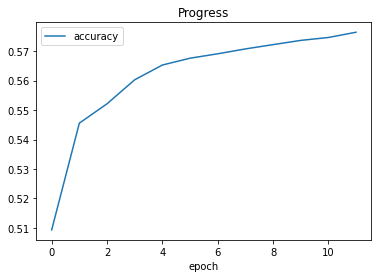

i=0 new_char: o (0.288) [best:  a (0.332), diff: 0.044, prob: 0.288, gap: 0.044]
i=1 new_char: s (0.083) [best:  l (0.167), diff: 0.084, prob: 0.024, gap: 0.128]
i=2 new_char: o (0.040) [best:  a (0.189), diff: 0.149, prob: 0.001, gap: 0.277]
i=3 new_char: n (0.267) [best:  n (0.267), diff: 0.000, prob: 0.000, gap: 0.277]
i=4 new_char: i (0.138) [best:  e (0.262), diff: 0.124, prob: 0.000, gap: 0.401]
i=5 new_char: t (0.057) [best:  e (0.226), diff: 0.169, prob: 0.000, gap: 0.571]
i=6 new_char: * (0.077) [best:  h (0.280), diff: 0.203, prob: 0.000, gap: 0.774]
josonit (probs: 0.000000, gap: 0.773730)
('josonit', {'probability': 1.5468257088033787e-07, 'gap': 0.7737300917506218})
i=0 new_char: d (0.067) [best:  m (0.101), diff: 0.033, prob: 0.067, gap: 0.033]
i=1 new_char: a (0.328) [best:  a (0.328), diff: 0.000, prob: 0.022, gap: 0.033]
i=2 new_char: n (0.215) [best:  n (0.215), diff: 0.000, prob: 0.005, gap: 0.033]
i=3 new_char: d (0.134) [best:  n (0.239), diff: 0.104, prob: 0.001, 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 9s 4ms/step - loss: 1.5737 - accuracy: 0.5269
Epoch 2/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.3850 - accuracy: 0.5574
Epoch 3/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.3363 - accuracy: 0.5721
Epoch 4/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.3081 - accuracy: 0.5806
Epoch 5/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.2902 - accuracy: 0.5838
Epoch 6/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.2772 - accuracy: 0.5879
Epoch 7/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.2666 - accuracy: 0.5896
Epoch 8/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.2578 - accuracy: 0.5925
Epoch 9/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.2499 - accuracy: 0.5938
Epoch 10/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.2431 - accurac

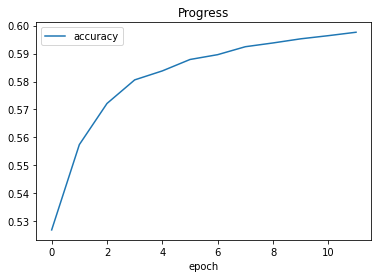

i=0 new_char: e (0.240) [best:  o (0.307), diff: 0.068, prob: 0.240, gap: 0.068]
i=1 new_char: s (0.155) [best:  n (0.225), diff: 0.070, prob: 0.037, gap: 0.138]
i=2 new_char: s (0.430) [best:  s (0.430), diff: 0.000, prob: 0.016, gap: 0.138]
i=3 new_char: y (0.076) [best:  a (0.317), diff: 0.241, prob: 0.001, gap: 0.379]
i=4 new_char: * (0.881) [best:  * (0.881), diff: 0.000, prob: 0.001, gap: 0.379]
jessy (probs: 0.001063, gap: 0.378628)
('jessy', {'probability': 0.0010632963127264492, 'gap': 0.37862761318683624})
i=0 new_char: d (0.075) [best:  a (0.094), diff: 0.019, prob: 0.075, gap: 0.019]
i=1 new_char: a (0.305) [best:  a (0.305), diff: 0.000, prob: 0.023, gap: 0.019]
i=2 new_char: n (0.261) [best:  n (0.261), diff: 0.000, prob: 0.006, gap: 0.019]
i=3 new_char: n (0.208) [best:  n (0.208), diff: 0.000, prob: 0.001, gap: 0.019]
i=4 new_char: a (0.194) [best:  i (0.319), diff: 0.124, prob: 0.000, gap: 0.143]
i=5 new_char: * (0.972) [best:  * (0.972), diff: 0.000, prob: 0.000, gap:

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 9s 4ms/step - loss: 1.5132 - accuracy: 0.5365
Epoch 2/12
1737/1737 [==============================] - 8s 4ms/step - loss: 1.3335 - accuracy: 0.5721
Epoch 3/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.2873 - accuracy: 0.5830
Epoch 4/12
1737/1737 [==============================] - 8s 4ms/step - loss: 1.2572 - accuracy: 0.5899
Epoch 5/12
1737/1737 [==============================] - 8s 4ms/step - loss: 1.2330 - accuracy: 0.5969
Epoch 6/12
1737/1737 [==============================] - 8s 4ms/step - loss: 1.2153 - accuracy: 0.6016
Epoch 7/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.1987 - accuracy: 0.6060
Epoch 8/12
1737/1737 [==============================] - 7s 4ms/step - loss: 1.1846 - accuracy: 0.6097
Epoch 9/12
1737/1737 [==============================] - 8s 4ms/step - loss: 1.1722 - accuracy: 0.6153
Epoch 10/12
1737/1737 [==============================] - 8s 4ms/step - loss: 1.1611 - accurac

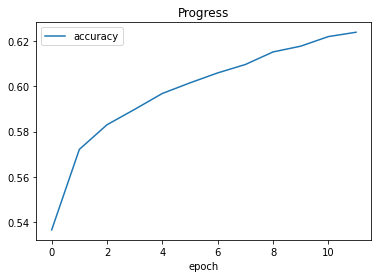

i=0 new_char: e (0.223) [best:  o (0.333), diff: 0.109, prob: 0.223, gap: 0.109]
i=1 new_char: r (0.070) [best:  s (0.251), diff: 0.181, prob: 0.016, gap: 0.290]
i=2 new_char: k (0.002) [best:  i (0.307), diff: 0.305, prob: 0.000, gap: 0.596]
i=3 new_char: a (0.445) [best:  a (0.445), diff: 0.000, prob: 0.000, gap: 0.596]
i=4 new_char: l (0.505) [best:  l (0.505), diff: 0.000, prob: 0.000, gap: 0.596]
i=5 new_char: a (0.073) [best:  i (0.447), diff: 0.373, prob: 0.000, gap: 0.969]
i=6 new_char: n (0.084) [best:  * (0.705), diff: 0.621, prob: 0.000, gap: 1.590]
i=7 new_char: t (0.026) [best:  d (0.313), diff: 0.287, prob: 0.000, gap: 1.877]
i=8 new_char: e (0.232) [best:  h (0.234), diff: 0.002, prob: 0.000, gap: 1.879]
i=9 new_char: a (0.134) [best:  * (0.663), diff: 0.529, prob: 0.000, gap: 2.408]
i=10 new_char: * (0.538) [best:  * (0.538), diff: 0.000, prob: 0.000, gap: 2.408]
jerkalantea (probs: 0.000000, gap: 2.407684)
('jerkalantea', {'probability': 2.1155389138214195e-11, 'gap': 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 10s 5ms/step - loss: 1.4652 - accuracy: 0.5482
Epoch 2/12
1737/1737 [==============================] - 8s 5ms/step - loss: 1.2972 - accuracy: 0.5794
Epoch 3/12
1737/1737 [==============================] - 8s 5ms/step - loss: 1.2419 - accuracy: 0.5966
Epoch 4/12
1737/1737 [==============================] - 8s 5ms/step - loss: 1.2012 - accuracy: 0.6050
Epoch 5/12
1737/1737 [==============================] - 8s 5ms/step - loss: 1.1676 - accuracy: 0.6160
Epoch 6/12
1737/1737 [==============================] - 8s 5ms/step - loss: 1.1399 - accuracy: 0.6217
Epoch 7/12
1737/1737 [==============================] - 8s 5ms/step - loss: 1.1150 - accuracy: 0.6306
Epoch 8/12
1737/1737 [==============================] - 8s 5ms/step - loss: 1.0941 - accuracy: 0.6350
Epoch 9/12
1737/1737 [==============================] - 8s 5ms/step - loss: 1.0767 - accuracy: 0.6400
Epoch 10/12
1737/1737 [==============================] - 8s 5ms/step - loss: 1.0610 - accura

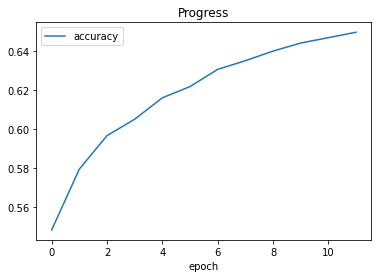

i=0 new_char: o (0.346) [best:  o (0.346), diff: 0.000, prob: 0.346, gap: 0.000]
i=1 new_char: l (0.151) [best:  s (0.185), diff: 0.035, prob: 0.052, gap: 0.035]
i=2 new_char: o (0.033) [best:  i (0.401), diff: 0.367, prob: 0.002, gap: 0.402]
i=3 new_char: a (0.007) [best:  r (0.268), diff: 0.262, prob: 0.000, gap: 0.664]
i=4 new_char: n (0.437) [best:  * (0.521), diff: 0.084, prob: 0.000, gap: 0.748]
i=5 new_char: * (0.272) [best:  n (0.322), diff: 0.050, prob: 0.000, gap: 0.797]
joloan (probs: 0.000001, gap: 0.797428)
('joloan', {'probability': 1.420506783038926e-06, 'gap': 0.7974280118942261})
i=0 new_char: a (0.093) [best:  a (0.093), diff: 0.000, prob: 0.093, gap: 0.000]
i=1 new_char: u (0.089) [best:  n (0.314), diff: 0.225, prob: 0.008, gap: 0.225]
i=2 new_char: d (0.095) [best:  r (0.522), diff: 0.426, prob: 0.001, gap: 0.651]
i=3 new_char: r (0.529) [best:  r (0.529), diff: 0.000, prob: 0.000, gap: 0.651]
i=4 new_char: i (0.253) [best:  e (0.460), diff: 0.207, prob: 0.000, gap

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 10s 5ms/step - loss: 1.4442 - accuracy: 0.5510
Epoch 2/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.2741 - accuracy: 0.5841
Epoch 3/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.2077 - accuracy: 0.6038
Epoch 4/12
1737/1737 [==============================] - 8s 5ms/step - loss: 1.1567 - accuracy: 0.6167
Epoch 5/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.1124 - accuracy: 0.6298
Epoch 6/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.0744 - accuracy: 0.6398
Epoch 7/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.0472 - accuracy: 0.6471
Epoch 8/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.0207 - accuracy: 0.6536
Epoch 9/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.0016 - accuracy: 0.6582
Epoch 10/12
1737/1737 [==============================] - 9s 5ms/step - loss: 0.9846 - accura

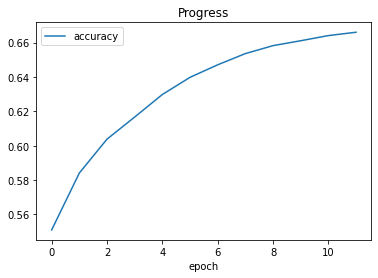

i=0 new_char: e (0.240) [best:  o (0.314), diff: 0.075, prob: 0.240, gap: 0.075]
i=1 new_char: n (0.462) [best:  n (0.462), diff: 0.000, prob: 0.111, gap: 0.075]
i=2 new_char: i (0.148) [best:  n (0.476), diff: 0.328, prob: 0.016, gap: 0.403]
i=3 new_char: l (0.188) [best:  l (0.188), diff: 0.000, prob: 0.003, gap: 0.403]
i=4 new_char: e (0.381) [best:  e (0.381), diff: 0.000, prob: 0.001, gap: 0.403]
i=5 new_char: e (0.627) [best:  e (0.627), diff: 0.000, prob: 0.001, gap: 0.403]
i=6 new_char: t (0.023) [best:  * (0.846), diff: 0.823, prob: 0.000, gap: 1.226]
i=7 new_char: * (0.645) [best:  * (0.645), diff: 0.000, prob: 0.000, gap: 1.226]
jenileet (probs: 0.000011, gap: 1.226017)
('jenileet', {'probability': 1.076518613021514e-05, 'gap': 1.2260169237852097})
i=0 new_char: w (0.012) [best:  c (0.097), diff: 0.085, prob: 0.012, gap: 0.085]
i=1 new_char: i (0.607) [best:  i (0.607), diff: 0.000, prob: 0.007, gap: 0.085]
i=2 new_char: n (0.364) [best:  l (0.602), diff: 0.238, prob: 0.003,

In [10]:
import itertools

rnn_types = ['LSTM']
rnn_units = [8, 16, 32, 64, 128]


for index, (rnn_type, rnn_unit) in enumerate(itertools.product(rnn_types, rnn_units)):
    print('-'*30 + '{0} ({1})'.format(rnn_type, rnn_unit) + '-'*30)
    parameters['rnn_type'] = rnn_type
    parameters['rnn_units'] = [rnn_unit]
    
    load_data(parameters)
    
    parameters["iter"] = 0
    parameters["total_epochs"] = 0
    parameters["history"] = {}

    model = create_model(parameters)
    compile_model(
        model,
        parameters
    )
    
    start = time.time()
    for i in range(len(parameters["epochs_to_run"])):
        train_model(model, parameters)
        parameters["iter"] = i
    end = time.time()
    print("Training took {0:.2f} seconds".format(end-start))
    
    plot_training_session(parameters, plots=["accuracy"])
    
    print(generate_name(model, parameters, start_char = 'j'))
    print(generate_name(model, parameters))

## Regularization techniques (dropout / recurrent_dropout)

------------------------------dropout: 0.0, recurrent dropout: 0.0------------------------------

5001 names split in 55584 training sequence of 5 encoded chars !
X shape: (55584, 5, 31)
Y shape: (55584, 31)
X[0] = [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]]
Y[0] = [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
Training set size: 55584
length_of_sequence: 5
number_of_chars: 31
some names: 0    #abagael*
1    #abagail*
2       #abbe*
3      #abbey*
4       #abbi*
Name: name, dtype: object
Model: "seq

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 10s 5ms/step - loss: 1.4449 - accuracy: 0.5508
Epoch 2/12
1737/1737 [==============================] - 8s 5ms/step - loss: 1.2768 - accuracy: 0.5837
Epoch 3/12
1737/1737 [==============================] - 8s 5ms/step - loss: 1.2101 - accuracy: 0.6027
Epoch 4/12
1737/1737 [==============================] - 8s 5ms/step - loss: 1.1592 - accuracy: 0.6165
Epoch 5/12
1737/1737 [==============================] - 8s 5ms/step - loss: 1.1160 - accuracy: 0.6299
Epoch 6/12
1737/1737 [==============================] - 8s 5ms/step - loss: 1.0778 - accuracy: 0.6406
Epoch 7/12
1737/1737 [==============================] - 8s 5ms/step - loss: 1.0482 - accuracy: 0.6476
Epoch 8/12
1737/1737 [==============================] - 8s 5ms/step - loss: 1.0230 - accuracy: 0.6534
Epoch 9/12
1737/1737 [==============================] - 8s 5ms/step - loss: 1.0040 - accuracy: 0.6560
Epoch 10/12
1737/1737 [==============================] - 8s 5ms/step - loss: 0.9861 - accura

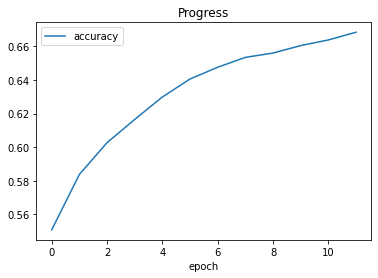

i=0 new_char: e (0.198) [best:  o (0.366), diff: 0.168, prob: 0.198, gap: 0.168]
i=1 new_char: a (0.204) [best:  n (0.271), diff: 0.067, prob: 0.040, gap: 0.235]
i=2 new_char: n (0.988) [best:  n (0.988), diff: 0.000, prob: 0.040, gap: 0.235]
i=3 new_char: i (0.106) [best:  e (0.365), diff: 0.259, prob: 0.004, gap: 0.493]
i=4 new_char: n (0.587) [best:  n (0.587), diff: 0.000, prob: 0.002, gap: 0.493]
i=5 new_char: e (0.646) [best:  e (0.646), diff: 0.000, prob: 0.002, gap: 0.493]
i=6 new_char: * (0.990) [best:  * (0.990), diff: 0.000, prob: 0.002, gap: 0.493]
jeanine (probs: 0.001597, gap: 0.493482)
('jeanine', {'probability': 0.0015967217710940386, 'gap': 0.4934816211462021})
i=0 new_char: y (0.004) [best:  m (0.102), diff: 0.098, prob: 0.004, gap: 0.098]
i=1 new_char: o (0.591) [best:  o (0.591), diff: 0.000, prob: 0.003, gap: 0.098]
i=2 new_char: n (0.164) [best:  l (0.315), diff: 0.150, prob: 0.000, gap: 0.248]
i=3 new_char: n (0.251) [best:  a (0.290), diff: 0.038, prob: 0.000, g

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 24s 13ms/step - loss: 1.4521 - accuracy: 0.5463
Epoch 2/12
1737/1737 [==============================] - 23s 13ms/step - loss: 1.2828 - accuracy: 0.5843
Epoch 3/12
1737/1737 [==============================] - 23s 13ms/step - loss: 1.2223 - accuracy: 0.5989
Epoch 4/12
1737/1737 [==============================] - 23s 13ms/step - loss: 1.1738 - accuracy: 0.6142
Epoch 5/12
1737/1737 [==============================] - 23s 13ms/step - loss: 1.1355 - accuracy: 0.6233
Epoch 6/12
1737/1737 [==============================] - 23s 13ms/step - loss: 1.1010 - accuracy: 0.6315
Epoch 7/12
1737/1737 [==============================] - 23s 13ms/step - loss: 1.0760 - accuracy: 0.6378
Epoch 8/12
1737/1737 [==============================] - 23s 13ms/step - loss: 1.0534 - accuracy: 0.6419
Epoch 9/12
1737/1737 [==============================] - 23s 13ms/step - loss: 1.0349 - accuracy: 0.6480
Epoch 10/12
1737/1737 [==============================] - 23s 13ms/step - lo

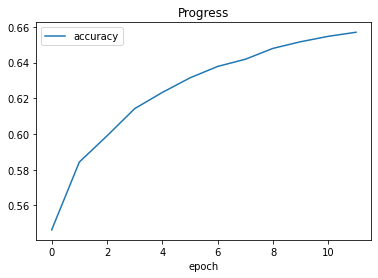

i=0 new_char: a (0.313) [best:  o (0.352), diff: 0.039, prob: 0.313, gap: 0.039]
i=1 new_char: n (0.319) [best:  c (0.476), diff: 0.157, prob: 0.100, gap: 0.196]
i=2 new_char: e (0.463) [best:  e (0.463), diff: 0.000, prob: 0.046, gap: 0.196]
i=3 new_char: l (0.248) [best:  t (0.368), diff: 0.120, prob: 0.011, gap: 0.316]
i=4 new_char: y (0.013) [best:  l (0.638), diff: 0.626, prob: 0.000, gap: 0.941]
i=5 new_char: * (0.838) [best:  * (0.838), diff: 0.000, prob: 0.000, gap: 0.941]
janely (probs: 0.000121, gap: 0.941378)
('janely', {'probability': 0.00012077965657273004, 'gap': 0.941378191113472})
i=0 new_char: m (0.104) [best:  m (0.104), diff: 0.000, prob: 0.104, gap: 0.000]
i=1 new_char: a (0.541) [best:  a (0.541), diff: 0.000, prob: 0.056, gap: 0.000]
i=2 new_char: d (0.129) [best:  r (0.502), diff: 0.373, prob: 0.007, gap: 0.373]
i=3 new_char: d (0.234) [best:  e (0.510), diff: 0.276, prob: 0.002, gap: 0.650]
i=4 new_char: y (0.324) [best:  i (0.428), diff: 0.104, prob: 0.001, gap

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 25s 13ms/step - loss: 1.4518 - accuracy: 0.5473
Epoch 2/12
1737/1737 [==============================] - 23s 13ms/step - loss: 1.2947 - accuracy: 0.5791
Epoch 3/12
1737/1737 [==============================] - 23s 13ms/step - loss: 1.2428 - accuracy: 0.5919
Epoch 4/12
1737/1737 [==============================] - 23s 13ms/step - loss: 1.2029 - accuracy: 0.6032
Epoch 5/12
1737/1737 [==============================] - 23s 13ms/step - loss: 1.1703 - accuracy: 0.6108
Epoch 6/12
1737/1737 [==============================] - 23s 13ms/step - loss: 1.1429 - accuracy: 0.6198
Epoch 7/12
1737/1737 [==============================] - 23s 13ms/step - loss: 1.1229 - accuracy: 0.6248
Epoch 8/12
1737/1737 [==============================] - 23s 13ms/step - loss: 1.1044 - accuracy: 0.6314
Epoch 9/12
1737/1737 [==============================] - 23s 13ms/step - loss: 1.0878 - accuracy: 0.6349
Epoch 10/12
1737/1737 [==============================] - 23s 13ms/step - lo

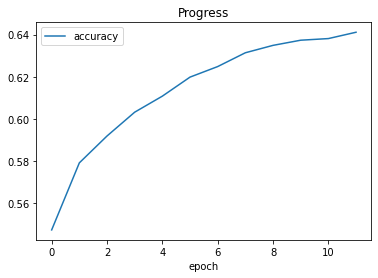

i=0 new_char: i (0.046) [best:  o (0.331), diff: 0.286, prob: 0.046, gap: 0.286]
i=1 new_char: l (0.731) [best:  l (0.731), diff: 0.000, prob: 0.033, gap: 0.286]
i=2 new_char: l (0.902) [best:  l (0.902), diff: 0.000, prob: 0.030, gap: 0.286]
i=3 new_char: e (0.264) [best:  e (0.264), diff: 0.000, prob: 0.008, gap: 0.286]
i=4 new_char: n (0.296) [best:  * (0.327), diff: 0.032, prob: 0.002, gap: 0.318]
i=5 new_char: * (0.260) [best:  e (0.548), diff: 0.288, prob: 0.001, gap: 0.606]
jillen (probs: 0.000610, gap: 0.606161)
('jillen', {'probability': 0.0006100459100830281, 'gap': 0.6061607897281647})
i=0 new_char: c (0.102) [best:  m (0.114), diff: 0.012, prob: 0.102, gap: 0.012]
i=1 new_char: o (0.155) [best:  a (0.421), diff: 0.265, prob: 0.016, gap: 0.277]
i=2 new_char: e (0.008) [best:  r (0.629), diff: 0.621, prob: 0.000, gap: 0.898]
i=3 new_char: l (0.482) [best:  l (0.482), diff: 0.000, prob: 0.000, gap: 0.898]
i=4 new_char: l (0.546) [best:  l (0.546), diff: 0.000, prob: 0.000, gap

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 10s 5ms/step - loss: 1.4886 - accuracy: 0.5422
Epoch 2/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.3474 - accuracy: 0.5702
Epoch 3/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.2966 - accuracy: 0.5826
Epoch 4/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.2562 - accuracy: 0.5933
Epoch 5/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.2295 - accuracy: 0.5976
Epoch 6/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.2030 - accuracy: 0.6053
Epoch 7/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.1849 - accuracy: 0.6095
Epoch 8/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.1710 - accuracy: 0.6147
Epoch 9/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.1550 - accuracy: 0.6180
Epoch 10/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.1390 - accura

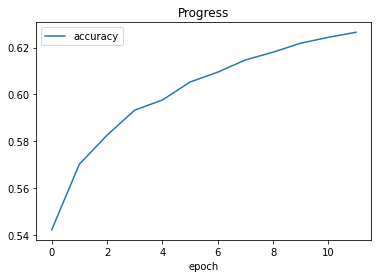

i=0 new_char: o (0.365) [best:  o (0.365), diff: 0.000, prob: 0.365, gap: 0.000]
i=1 new_char: b (0.071) [best:  a (0.171), diff: 0.100, prob: 0.026, gap: 0.100]
i=2 new_char: i (0.369) [best:  y (0.391), diff: 0.022, prob: 0.010, gap: 0.122]
i=3 new_char: e (0.519) [best:  e (0.519), diff: 0.000, prob: 0.005, gap: 0.122]
i=4 new_char: l (0.016) [best:  * (0.915), diff: 0.899, prob: 0.000, gap: 1.022]
i=5 new_char: e (0.025) [best:  l (0.792), diff: 0.767, prob: 0.000, gap: 1.788]
i=6 new_char: * (0.547) [best:  * (0.547), diff: 0.000, prob: 0.000, gap: 1.788]
jobiele (probs: 0.000001, gap: 1.788373)
('jobiele', {'probability': 1.0695159808305175e-06, 'gap': 1.7883728742599487})
i=0 new_char: r (0.050) [best:  c (0.103), diff: 0.053, prob: 0.050, gap: 0.053]
i=1 new_char: e (0.158) [best:  o (0.349), diff: 0.191, prob: 0.008, gap: 0.244]
i=2 new_char: b (0.128) [best:  n (0.301), diff: 0.172, prob: 0.001, gap: 0.416]
i=3 new_char: a (0.127) [best:  e (0.595), diff: 0.468, prob: 0.000, 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 27s 14ms/step - loss: 1.4775 - accuracy: 0.5424
Epoch 2/12
1737/1737 [==============================] - 25s 14ms/step - loss: 1.3269 - accuracy: 0.5744
Epoch 3/12
1737/1737 [==============================] - 25s 14ms/step - loss: 1.2755 - accuracy: 0.5847
Epoch 4/12
1737/1737 [==============================] - 25s 14ms/step - loss: 1.2338 - accuracy: 0.5971
Epoch 5/12
1737/1737 [==============================] - 25s 14ms/step - loss: 1.2038 - accuracy: 0.6020
Epoch 6/12
1737/1737 [==============================] - 25s 14ms/step - loss: 1.1761 - accuracy: 0.6102
Epoch 7/12
1737/1737 [==============================] - 25s 14ms/step - loss: 1.1556 - accuracy: 0.6161
Epoch 8/12
1737/1737 [==============================] - 25s 14ms/step - loss: 1.1381 - accuracy: 0.6204
Epoch 9/12
1737/1737 [==============================] - 25s 14ms/step - loss: 1.1236 - accuracy: 0.6257
Epoch 10/12
1737/1737 [==============================] - 25s 14ms/step - lo

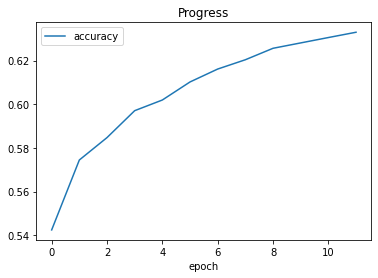

i=0 new_char: o (0.250) [best:  a (0.285), diff: 0.035, prob: 0.250, gap: 0.035]
i=1 new_char: e (0.102) [best:  s (0.186), diff: 0.084, prob: 0.025, gap: 0.119]
i=2 new_char: n (0.114) [best:  l (0.537), diff: 0.423, prob: 0.003, gap: 0.541]
i=3 new_char: a (0.182) [best:  e (0.297), diff: 0.115, prob: 0.001, gap: 0.657]
i=4 new_char: * (0.930) [best:  * (0.930), diff: 0.000, prob: 0.000, gap: 0.657]
joena (probs: 0.000490, gap: 0.656796)
('joena', {'probability': 0.0004900370763617223, 'gap': 0.6567961871623993})
i=0 new_char: i (0.020) [best:  m (0.090), diff: 0.070, prob: 0.020, gap: 0.070]
i=1 new_char: d (0.087) [best:  n (0.206), diff: 0.119, prob: 0.002, gap: 0.189]
i=2 new_char: e (0.451) [best:  e (0.451), diff: 0.000, prob: 0.001, gap: 0.189]
i=3 new_char: l (0.538) [best:  l (0.538), diff: 0.000, prob: 0.000, gap: 0.189]
i=4 new_char: o (0.002) [best:  l (0.723), diff: 0.721, prob: 0.000, gap: 0.910]
i=5 new_char: n (0.272) [best:  r (0.328), diff: 0.055, prob: 0.000, gap: 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 27s 14ms/step - loss: 1.4863 - accuracy: 0.5413
Epoch 2/12
1737/1737 [==============================] - 25s 14ms/step - loss: 1.3381 - accuracy: 0.5707
Epoch 3/12
1737/1737 [==============================] - 25s 14ms/step - loss: 1.2875 - accuracy: 0.5805
Epoch 4/12
1737/1737 [==============================] - 25s 14ms/step - loss: 1.2512 - accuracy: 0.5900
Epoch 5/12
1737/1737 [==============================] - 25s 14ms/step - loss: 1.2280 - accuracy: 0.5974
Epoch 6/12
1737/1737 [==============================] - 25s 14ms/step - loss: 1.2070 - accuracy: 0.6031
Epoch 7/12
1737/1737 [==============================] - 25s 14ms/step - loss: 1.1888 - accuracy: 0.6073
Epoch 8/12
1737/1737 [==============================] - 25s 14ms/step - loss: 1.1751 - accuracy: 0.6082
Epoch 9/12
1737/1737 [==============================] - 25s 14ms/step - loss: 1.1651 - accuracy: 0.6132
Epoch 10/12
1737/1737 [==============================] - 25s 14ms/step - lo

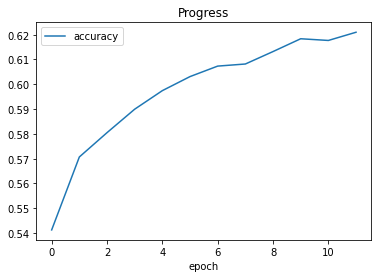

i=0 new_char: i (0.034) [best:  a (0.349), diff: 0.315, prob: 0.034, gap: 0.315]
i=1 new_char: a (0.052) [best:  l (0.572), diff: 0.520, prob: 0.002, gap: 0.835]
i=2 new_char: n (0.929) [best:  n (0.929), diff: 0.000, prob: 0.002, gap: 0.835]
i=3 new_char: * (0.112) [best:  n (0.529), diff: 0.417, prob: 0.000, gap: 1.252]
jian (probs: 0.000183, gap: 1.252255)
('jian', {'probability': 0.00018266930733884282, 'gap': 1.2522549629211426})
i=0 new_char: j (0.065) [best:  m (0.102), diff: 0.037, prob: 0.065, gap: 0.037]
i=1 new_char: o (0.339) [best:  a (0.349), diff: 0.010, prob: 0.022, gap: 0.047]
i=2 new_char: s (0.156) [best:  s (0.156), diff: 0.000, prob: 0.003, gap: 0.047]
i=3 new_char: a (0.215) [best:  e (0.419), diff: 0.204, prob: 0.001, gap: 0.251]
i=4 new_char: n (0.360) [best:  n (0.360), diff: 0.000, prob: 0.000, gap: 0.251]
i=5 new_char: n (0.630) [best:  n (0.630), diff: 0.000, prob: 0.000, gap: 0.251]
i=6 new_char: a (0.507) [best:  a (0.507), diff: 0.000, prob: 0.000, gap: 0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 11s 5ms/step - loss: 1.5872 - accuracy: 0.5252
Epoch 2/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.4780 - accuracy: 0.5435
Epoch 3/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.4433 - accuracy: 0.5502
Epoch 4/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.4270 - accuracy: 0.5526
Epoch 5/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.4068 - accuracy: 0.5590
Epoch 6/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.3961 - accuracy: 0.5603
Epoch 7/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.3891 - accuracy: 0.5604
Epoch 8/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.3758 - accuracy: 0.5649
Epoch 9/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.3723 - accuracy: 0.5655
Epoch 10/12
1737/1737 [==============================] - 9s 5ms/step - loss: 1.3639 - accura

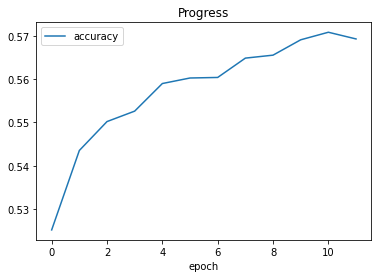

i=0 new_char: e (0.195) [best:  o (0.375), diff: 0.180, prob: 0.195, gap: 0.180]
i=1 new_char: e (0.044) [best:  n (0.230), diff: 0.187, prob: 0.009, gap: 0.367]
i=2 new_char: a (0.072) [best:  n (0.232), diff: 0.160, prob: 0.001, gap: 0.527]
i=3 new_char: * (0.230) [best:  n (0.347), diff: 0.117, prob: 0.000, gap: 0.644]
jeea (probs: 0.000141, gap: 0.643585)
('jeea', {'probability': 0.00014087332484669137, 'gap': 0.6435853242874146})
i=0 new_char: e (0.054) [best:  a (0.099), diff: 0.044, prob: 0.054, gap: 0.044]
i=1 new_char: b (0.026) [best:  l (0.196), diff: 0.170, prob: 0.001, gap: 0.214]
i=2 new_char: e (0.257) [best:  e (0.257), diff: 0.000, prob: 0.000, gap: 0.214]
i=3 new_char: n (0.134) [best:  l (0.215), diff: 0.082, prob: 0.000, gap: 0.296]
i=4 new_char: t (0.058) [best:  a (0.194), diff: 0.136, prob: 0.000, gap: 0.432]
i=5 new_char: i (0.204) [best:  a (0.338), diff: 0.133, prob: 0.000, gap: 0.566]
i=6 new_char: c (0.034) [best:  n (0.268), diff: 0.234, prob: 0.000, gap: 0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 27s 15ms/step - loss: 1.5443 - accuracy: 0.5301
Epoch 2/12
1737/1737 [==============================] - 25s 15ms/step - loss: 1.3959 - accuracy: 0.5567
Epoch 3/12
1737/1737 [==============================] - 25s 15ms/step - loss: 1.3490 - accuracy: 0.5683
Epoch 4/12
1737/1737 [==============================] - 25s 15ms/step - loss: 1.3206 - accuracy: 0.5734
Epoch 5/12
1737/1737 [==============================] - 26s 15ms/step - loss: 1.2984 - accuracy: 0.5806
Epoch 6/12
1737/1737 [==============================] - 26s 15ms/step - loss: 1.2805 - accuracy: 0.5848
Epoch 7/12
1737/1737 [==============================] - 26s 15ms/step - loss: 1.2672 - accuracy: 0.5866
Epoch 8/12
1737/1737 [==============================] - 25s 15ms/step - loss: 1.2563 - accuracy: 0.5911
Epoch 9/12
1737/1737 [==============================] - 26s 15ms/step - loss: 1.2448 - accuracy: 0.5947
Epoch 10/12
1737/1737 [==============================] - 25s 15ms/step - lo

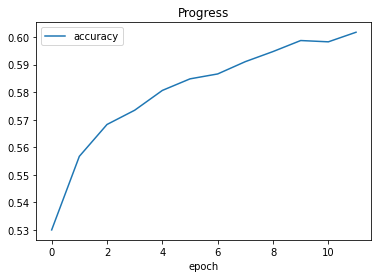

i=0 new_char: o (0.345) [best:  o (0.345), diff: 0.000, prob: 0.345, gap: 0.000]
i=1 new_char: a (0.056) [best:  s (0.207), diff: 0.151, prob: 0.019, gap: 0.151]
i=2 new_char: n (0.758) [best:  n (0.758), diff: 0.000, prob: 0.015, gap: 0.151]
i=3 new_char: n (0.479) [best:  n (0.479), diff: 0.000, prob: 0.007, gap: 0.151]
i=4 new_char: * (0.183) [best:  e (0.457), diff: 0.274, prob: 0.001, gap: 0.425]
joann (probs: 0.001292, gap: 0.424562)
('joann', {'probability': 0.0012917566395361823, 'gap': 0.42456187307834625})
i=0 new_char: a (0.089) [best:  c (0.099), diff: 0.009, prob: 0.089, gap: 0.009]
i=1 new_char: n (0.245) [best:  n (0.245), diff: 0.000, prob: 0.022, gap: 0.009]
i=2 new_char: d (0.215) [best:  n (0.346), diff: 0.131, prob: 0.005, gap: 0.141]
i=3 new_char: i (0.139) [best:  r (0.427), diff: 0.288, prob: 0.001, gap: 0.428]
i=4 new_char: a (0.177) [best:  e (0.314), diff: 0.136, prob: 0.000, gap: 0.565]
i=5 new_char: * (0.956) [best:  * (0.956), diff: 0.000, prob: 0.000, gap:

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 28s 15ms/step - loss: 1.5497 - accuracy: 0.5301
Epoch 2/12
1737/1737 [==============================] - 26s 15ms/step - loss: 1.4046 - accuracy: 0.5542
Epoch 3/12
1737/1737 [==============================] - 26s 15ms/step - loss: 1.3603 - accuracy: 0.5655
Epoch 4/12
1737/1737 [==============================] - 26s 15ms/step - loss: 1.3334 - accuracy: 0.5719
Epoch 5/12
1737/1737 [==============================] - 26s 15ms/step - loss: 1.3188 - accuracy: 0.5748
Epoch 6/12
1737/1737 [==============================] - 26s 15ms/step - loss: 1.2990 - accuracy: 0.5802
Epoch 7/12
1737/1737 [==============================] - 25s 15ms/step - loss: 1.2870 - accuracy: 0.5825
Epoch 8/12
1737/1737 [==============================] - 25s 15ms/step - loss: 1.2779 - accuracy: 0.5859
Epoch 9/12
1737/1737 [==============================] - 25s 15ms/step - loss: 1.2663 - accuracy: 0.5857
Epoch 10/12
1737/1737 [==============================] - 26s 15ms/step - lo

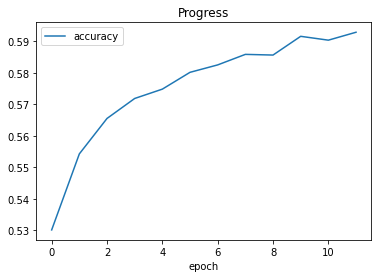

i=0 new_char: o (0.363) [best:  o (0.363), diff: 0.000, prob: 0.363, gap: 0.000]
i=1 new_char: l (0.137) [best:  s (0.145), diff: 0.009, prob: 0.050, gap: 0.009]
i=2 new_char: a (0.109) [best:  i (0.322), diff: 0.213, prob: 0.005, gap: 0.221]
i=3 new_char: n (0.625) [best:  n (0.625), diff: 0.000, prob: 0.003, gap: 0.221]
i=4 new_char: e (0.180) [best:  n (0.267), diff: 0.088, prob: 0.001, gap: 0.309]
i=5 new_char: t (0.032) [best:  * (0.906), diff: 0.874, prob: 0.000, gap: 1.183]
i=6 new_char: h (0.107) [best:  t (0.738), diff: 0.631, prob: 0.000, gap: 1.814]
i=7 new_char: a (0.128) [best:  * (0.666), diff: 0.539, prob: 0.000, gap: 2.353]
i=8 new_char: * (0.967) [best:  * (0.967), diff: 0.000, prob: 0.000, gap: 2.353]
jolanetha (probs: 0.000000, gap: 2.353146)
('jolanetha', {'probability': 2.5931012403959433e-07, 'gap': 2.3531462103128433})
i=0 new_char: h (0.023) [best:  c (0.101), diff: 0.078, prob: 0.023, gap: 0.078]
i=1 new_char: e (0.316) [best:  a (0.354), diff: 0.038, prob: 0.0

In [11]:
dropout_rates = [0.0, 0.1, 0.3]

# use the same model, but change the regularization
parameters['rnn_type'] = 'LSTM'
parameters['rnn_units'] = [128]

for index, (dropout, recurrent_dropout) in enumerate(itertools.product(dropout_rates, dropout_rates)):
    print('-'*30 + 'dropout: {0}, recurrent dropout: {1}'.format(dropout, recurrent_dropout) + '-'*30)
    parameters['dropout'] = dropout
    parameters['recurrent_dropout'] = recurrent_dropout

    load_data(parameters)
    
    parameters["iter"] = 0
    parameters["total_epochs"] = 0
    parameters["history"] = {}

    model = create_model(parameters)
    compile_model(
        model,
        parameters
    )
    
    start = time.time()
    for i in range(len(parameters["epochs_to_run"])):
        train_model(model, parameters)
        parameters["iter"] = i
    end = time.time()
    print("Training took {0:.2f} seconds".format(end-start))
    
    plot_training_session(parameters, plots=["accuracy"])
    
    print(generate_name(model, parameters, start_char = 'j'))
    print(generate_name(model, parameters))


##Stack several RNN layers

------------------------------stack: 1------------------------------

5001 names split in 55584 training sequence of 5 encoded chars !
X shape: (55584, 5, 31)
Y shape: (55584, 31)
X[0] = [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]]
Y[0] = [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
Training set size: 55584
length_of_sequence: 5
number_of_chars: 31
some names: 0    #abagael*
1    #abagail*
2       #abbe*
3      #abbey*
4       #abbi*
Name: name, dtype: object
Model: "sequential_18"
________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 24s 13ms/step - loss: 1.4853 - accuracy: 0.5432
Epoch 2/12
1737/1737 [==============================] - 22s 13ms/step - loss: 1.3146 - accuracy: 0.5758
Epoch 3/12
1737/1737 [==============================] - 22s 13ms/step - loss: 1.2684 - accuracy: 0.5884
Epoch 4/12
1737/1737 [==============================] - 22s 13ms/step - loss: 1.2345 - accuracy: 0.5947
Epoch 5/12
1737/1737 [==============================] - 22s 13ms/step - loss: 1.2088 - accuracy: 0.6014
Epoch 6/12
1737/1737 [==============================] - 22s 13ms/step - loss: 1.1883 - accuracy: 0.6092
Epoch 7/12
1737/1737 [==============================] - 22s 13ms/step - loss: 1.1690 - accuracy: 0.6136
Epoch 8/12
1737/1737 [==============================] - 22s 13ms/step - loss: 1.1542 - accuracy: 0.6167
Epoch 9/12
1737/1737 [==============================] - 22s 13ms/step - loss: 1.1431 - accuracy: 0.6201
Epoch 10/12
1737/1737 [==============================] - 22s 13ms/step - lo

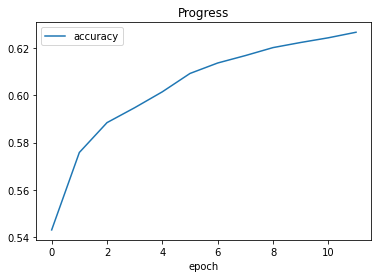

i=0 new_char: e (0.237) [best:  o (0.309), diff: 0.072, prob: 0.237, gap: 0.072]
i=1 new_char: n (0.446) [best:  n (0.446), diff: 0.000, prob: 0.106, gap: 0.072]
i=2 new_char: i (0.195) [best:  n (0.400), diff: 0.205, prob: 0.021, gap: 0.277]
i=3 new_char: e (0.182) [best:  c (0.187), diff: 0.005, prob: 0.004, gap: 0.282]
i=4 new_char: * (0.816) [best:  * (0.816), diff: 0.000, prob: 0.003, gap: 0.282]
jenie (probs: 0.003060, gap: 0.281559)
('jenie', {'probability': 0.003059933854443747, 'gap': 0.28155870735645294})
i=0 new_char: e (0.045) [best:  m (0.090), diff: 0.045, prob: 0.045, gap: 0.045]
i=1 new_char: d (0.094) [best:  l (0.344), diff: 0.249, prob: 0.004, gap: 0.294]
i=2 new_char: i (0.252) [best:  i (0.252), diff: 0.000, prob: 0.001, gap: 0.294]
i=3 new_char: n (0.067) [best:  t (0.310), diff: 0.243, prob: 0.000, gap: 0.537]
i=4 new_char: e (0.409) [best:  e (0.409), diff: 0.000, prob: 0.000, gap: 0.537]
i=5 new_char: * (0.991) [best:  * (0.991), diff: 0.000, prob: 0.000, gap: 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 47s 25ms/step - loss: 1.4990 - accuracy: 0.5393
Epoch 2/12
1737/1737 [==============================] - 44s 25ms/step - loss: 1.3150 - accuracy: 0.5776
Epoch 3/12
1737/1737 [==============================] - 45s 26ms/step - loss: 1.2491 - accuracy: 0.5923
Epoch 4/12
1737/1737 [==============================] - 45s 26ms/step - loss: 1.2054 - accuracy: 0.6040
Epoch 5/12
1737/1737 [==============================] - 44s 25ms/step - loss: 1.1719 - accuracy: 0.6119
Epoch 6/12
1737/1737 [==============================] - 44s 25ms/step - loss: 1.1459 - accuracy: 0.6196
Epoch 7/12
1737/1737 [==============================] - 44s 25ms/step - loss: 1.1240 - accuracy: 0.6257
Epoch 8/12
1737/1737 [==============================] - 44s 25ms/step - loss: 1.1067 - accuracy: 0.6302
Epoch 9/12
1737/1737 [==============================] - 44s 26ms/step - loss: 1.0898 - accuracy: 0.6356
Epoch 10/12
1737/1737 [==============================] - 44s 25ms/step - lo

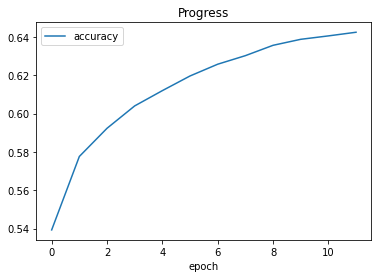

i=0 new_char: a (0.264) [best:  o (0.312), diff: 0.048, prob: 0.264, gap: 0.048]
i=1 new_char: c (0.259) [best:  n (0.515), diff: 0.257, prob: 0.068, gap: 0.305]
i=2 new_char: q (0.518) [best:  q (0.518), diff: 0.000, prob: 0.035, gap: 0.305]
i=3 new_char: u (0.998) [best:  u (0.998), diff: 0.000, prob: 0.035, gap: 0.305]
i=4 new_char: a (0.026) [best:  e (0.773), diff: 0.747, prob: 0.001, gap: 1.052]
i=5 new_char: * (0.779) [best:  * (0.779), diff: 0.000, prob: 0.001, gap: 1.052]
jacqua (probs: 0.000718, gap: 1.051824)
('jacqua', {'probability': 0.0007180398888734997, 'gap': 1.0518238544464111})
i=0 new_char: t (0.038) [best:  c (0.103), diff: 0.065, prob: 0.038, gap: 0.065]
i=1 new_char: h (0.114) [best:  a (0.238), diff: 0.124, prob: 0.004, gap: 0.189]
i=2 new_char: e (0.769) [best:  e (0.769), diff: 0.000, prob: 0.003, gap: 0.189]
i=3 new_char: r (0.664) [best:  r (0.664), diff: 0.000, prob: 0.002, gap: 0.189]
i=4 new_char: r (0.053) [best:  e (0.632), diff: 0.579, prob: 0.000, gap

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 70s 37ms/step - loss: 1.5274 - accuracy: 0.5322
Epoch 2/12
1737/1737 [==============================] - 65s 38ms/step - loss: 1.3582 - accuracy: 0.5647
Epoch 3/12
1737/1737 [==============================] - 64s 37ms/step - loss: 1.2810 - accuracy: 0.5828
Epoch 4/12
1737/1737 [==============================] - 64s 37ms/step - loss: 1.2298 - accuracy: 0.5951
Epoch 5/12
1737/1737 [==============================] - 64s 37ms/step - loss: 1.1883 - accuracy: 0.6065
Epoch 6/12
1737/1737 [==============================] - 65s 38ms/step - loss: 1.1565 - accuracy: 0.6172
Epoch 7/12
1737/1737 [==============================] - 65s 37ms/step - loss: 1.1301 - accuracy: 0.6240
Epoch 8/12
1737/1737 [==============================] - 65s 37ms/step - loss: 1.1121 - accuracy: 0.6271
Epoch 9/12
1737/1737 [==============================] - 65s 37ms/step - loss: 1.0942 - accuracy: 0.6350
Epoch 10/12
1737/1737 [==============================] - 65s 37ms/step - lo

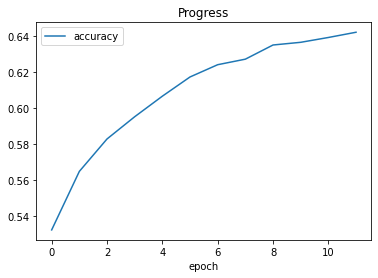

i=0 new_char: u (0.158) [best:  o (0.333), diff: 0.175, prob: 0.158, gap: 0.175]
i=1 new_char: l (0.471) [best:  l (0.471), diff: 0.000, prob: 0.074, gap: 0.175]
i=2 new_char: i (0.814) [best:  i (0.814), diff: 0.000, prob: 0.060, gap: 0.175]
i=3 new_char: a (0.306) [best:  e (0.354), diff: 0.048, prob: 0.019, gap: 0.224]
i=4 new_char: n (0.623) [best:  n (0.623), diff: 0.000, prob: 0.012, gap: 0.224]
i=5 new_char: n (0.501) [best:  n (0.501), diff: 0.000, prob: 0.006, gap: 0.224]
i=6 new_char: e (0.436) [best:  e (0.436), diff: 0.000, prob: 0.003, gap: 0.224]
i=7 new_char: * (0.977) [best:  * (0.977), diff: 0.000, prob: 0.002, gap: 0.224]
julianne (probs: 0.002460, gap: 0.223676)
('julianne', {'probability': 0.0024604093748059027, 'gap': 0.22367629408836365})
i=0 new_char: m (0.109) [best:  m (0.109), diff: 0.000, prob: 0.109, gap: 0.000]
i=1 new_char: i (0.074) [best:  a (0.622), diff: 0.548, prob: 0.008, gap: 0.548]
i=2 new_char: t (0.057) [best:  c (0.247), diff: 0.190, prob: 0.000

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1737/1737 [==============================] - 90s 49ms/step - loss: 1.5407 - accuracy: 0.5284
Epoch 2/12
1737/1737 [==============================] - 86s 50ms/step - loss: 1.4010 - accuracy: 0.5533
Epoch 3/12
1737/1737 [==============================] - 87s 50ms/step - loss: 1.3513 - accuracy: 0.5653
Epoch 4/12
1737/1737 [==============================] - 85s 49ms/step - loss: 1.3015 - accuracy: 0.5796
Epoch 5/12
1737/1737 [==============================] - 86s 50ms/step - loss: 1.2606 - accuracy: 0.5882
Epoch 6/12
1737/1737 [==============================] - 86s 49ms/step - loss: 1.2237 - accuracy: 0.5975
Epoch 7/12
1737/1737 [==============================] - 88s 51ms/step - loss: 1.1948 - accuracy: 0.6053
Epoch 8/12
1737/1737 [==============================] - 86s 49ms/step - loss: 1.1718 - accuracy: 0.6115
Epoch 9/12
1737/1737 [==============================] - 86s 49ms/step - loss: 1.1490 - accuracy: 0.6160
Epoch 10/12
1737/1737 [==============================] - 85s 49ms/step - lo

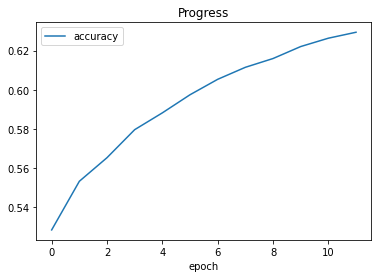

i=0 new_char: u (0.061) [best:  a (0.399), diff: 0.338, prob: 0.061, gap: 0.338]
i=1 new_char: t (0.017) [best:  l (0.516), diff: 0.499, prob: 0.001, gap: 0.837]
i=2 new_char: e (0.075) [best:  h (0.526), diff: 0.451, prob: 0.000, gap: 1.288]
i=3 new_char: l (0.155) [best:  * (0.459), diff: 0.305, prob: 0.000, gap: 1.593]
i=4 new_char: l (0.269) [best:  * (0.276), diff: 0.007, prob: 0.000, gap: 1.600]
i=5 new_char: a (0.520) [best:  a (0.520), diff: 0.000, prob: 0.000, gap: 1.600]
i=6 new_char: * (0.966) [best:  * (0.966), diff: 0.000, prob: 0.000, gap: 1.600]
jutella (probs: 0.000002, gap: 1.599773)
('jutella', {'probability': 1.6232151962355296e-06, 'gap': 1.5997725427150726})
i=0 new_char: m (0.126) [best:  m (0.126), diff: 0.000, prob: 0.126, gap: 0.000]
i=1 new_char: a (0.534) [best:  a (0.534), diff: 0.000, prob: 0.067, gap: 0.000]
i=2 new_char: r (0.515) [best:  r (0.515), diff: 0.000, prob: 0.035, gap: 0.000]
i=3 new_char: t (0.099) [best:  i (0.274), diff: 0.175, prob: 0.003, 

In [12]:
stacks = [1, 2, 3, 4]
base_unit = [64]

parameters['rnn_type'] = 'LSTM'
parameters['dropout'] = 0.0
parameters['recurrent_dropout'] = 0.2

for index, stack in enumerate(stacks):
    print('-'*30 + 'stack: {0}'.format(stack) + '-'*30)
    parameters['rnn_units'] = base_unit * stack
    
    load_data(parameters)
    
    parameters["iter"] = 0
    parameters["total_epochs"] = 0
    parameters["history"] = {}

    model = create_model(parameters)
    compile_model(
        model,
        parameters
    )

    start = time.time()
    for i in range(len(parameters["epochs_to_run"])):
        train_model(model, parameters)
        parameters["iter"] = i
    end = time.time()
    print("Training took {0:.2f} seconds".format(end-start))
    
    plot_training_session(parameters, plots=["accuracy"])
    
    print(generate_name(model, parameters, start_char = 'j'))
    print(generate_name(model, parameters))